In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import pickle


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from src.common.helperfunctions import *

import xgboost as xgb
import time
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, precision_score, f1_score, accuracy_score, confusion_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_name = 'data/raw/creditcard.csv'
df = pd.read_csv(file_name)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# label_col = []
# feature_cols = []
# label_col = [i for i in df.columns if 'Class' in i]
# feature_cols = [i for i in df.columns if i not in label_col]

In [4]:
# X = df.loc[:,feature_cols]
# y = df.loc[:,label_col]

In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [6]:
sc = StandardScaler()
train.loc[:,'Amount'] = sc.fit_transform(train.Amount.values.reshape(-1, 1))
train.loc[:,'Time'] = sc.fit_transform(train.Time.values.reshape(-1, 1))
test.loc[:,'Amount'] = sc.transform(test.Amount.values.reshape(-1, 1))
test.loc[:,'Time'] = sc.transform(test.Time.values.reshape(-1, 1))
# train.drop('Time',axis=1, inplace=True)
# test.drop('Time', axis=1, inplace=True)

/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [7]:
train_y = train.Class
train_X = train
train_X.drop('Class', axis=1, inplace=True)
test_y = test.Class
test_X = test
test_X.drop('Class', axis=1, inplace=True)


/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
print(f'Train size: {train_X.shape}, Test size: {test_X.shape}')

Train size: (227845, 30), Test size: (56962, 30)


In [9]:
# print(f'Class in train: {train_y.Class[train_y.Class == 1].count()}, and in test: {test_y.Class[test_y.Class == 1].count()}')

In [10]:
label_col = []
feature_cols = []
label_col = ['Class']
feature_cols = [i for i in train_X.columns]

# Smote

In [11]:
from imblearn.over_sampling import SMOTE

In [12]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
train_X, train_y = smote.fit_sample(train_X, train_y)
train_X = pd.DataFrame(data=train_X, columns = feature_cols)
train_y = pd.DataFrame(data=train_y, columns = label_col)

In [13]:
print(f'Fraud cases in train: {train_y.Class[train_y.Class == 1].count()}, and normal transactions in train: {train_y.Class[train_y.Class == 0].count()}')

Fraud cases in train: 227451, and normal transactions in train: 227451


## XGBoost

In [14]:
start_time = time.time()
dtrain = xgb.DMatrix(train_X, train_y, feature_names=feature_cols)
dtest = xgb.DMatrix(test_X, feature_names=feature_cols)

results_dict = {}

param = {
        'max_depth':5, 
        'eta':0.3, 
        'verbosity': 1, 
        'objective':'binary:logistic', 
        'eval_metric': 'auc', 
        'seed': 42
        }

model = xgb.train(param, dtrain, num_boost_round=100)
# make prediction
preds = model.predict(dtest)
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

Time elapsed to train:  45.957027435302734


In [15]:
preds = preds.round()

In [16]:
print('---' * 45)
print('XGBoost ROC/AUC: {:.6f}'.format(roc_auc_score(test_y, preds)))
print('Recall Score: {:.6f}'.format(recall_score(test_y, preds)))
print('Precision Score: {:.6f}'.format(precision_score(test_y, preds)))
print('F1 Score: {:.6f}'.format(f1_score(test_y, preds)))
print('Accuracy Score: {:.6f}'.format(accuracy_score(test_y, preds)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
XGBoost ROC/AUC: 0.923355
Recall Score: 0.846939
Precision Score: 0.864583
F1 Score: 0.855670
Accuracy Score: 0.999508
---------------------------------------------------------------------------------------------------------------------------------------


In [17]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve

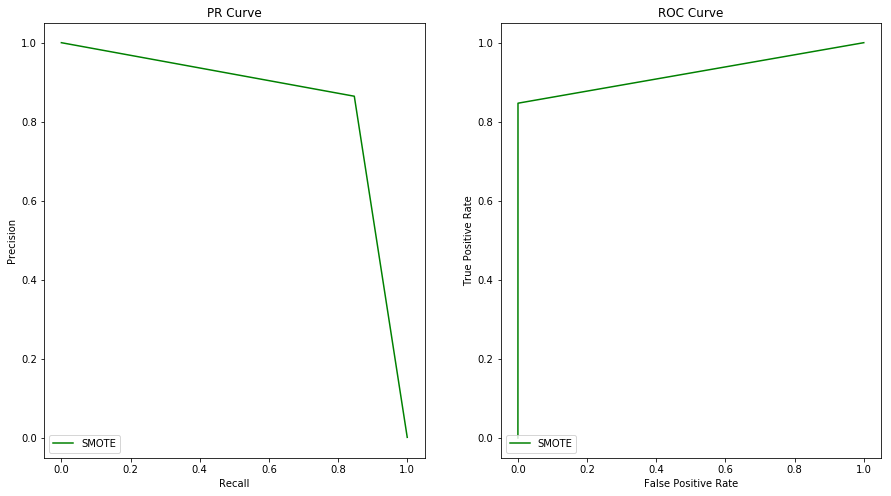

In [19]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')


p,r,_ = precision_recall_curve(test_y,preds)
tpr,fpr,_ = roc_curve(test_y,preds)

ax1.plot(r,p,c='g',label='SMOTE')
ax2.plot(tpr,fpr,c='g',label='SMOTE')
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()